In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'

# dirAgData = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'
# dirEra5 = '/dartfs-hpc/rc/lab/C/CMIG/ERA5'

In [4]:
yearRange = [1981, 2019]

In [5]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [8]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)
    
with open('%s/kdd-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    kdd_trends = pickle.load(f)
with open('%s/gdd-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    gdd_trends = pickle.load(f)
with open('%s/pr-era5-trends-Maize-1981-2019.dat'%dirAgData, 'rb') as f:
    pr_trends = pickle.load(f)

In [92]:
# for y, year in enumerate(range(1981, 2019+1)):
#     os.rename('heat_wave_days/era5_cold_wave_days_%d.dat'%year, 'heat_wave_days/era5_t_min_wave_days_%d.dat'%year)

In [13]:
with open('growing_season_len_maize.dat', 'rb') as f:
    growing_season_len = pickle.load(f)

wave_days_t_max = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1981, 2019+1)), 6], np.nan)
wave_days_t_min = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1981, 2019+1)), 6], np.nan)
wave_days_tw_max = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1981, 2019+1)), 6], np.nan)
wave_days_tw_min = np.full([growing_season_len.shape[0], growing_season_len.shape[1], len(range(1981, 2019+1)), 6], np.nan)
for y, year in enumerate(range(1981, 2019+1)):
    if y % 5 == 0:
        print(year)
    with open('heat_wave_days/era5_t_max_wave_days_%d.dat'%year, 'rb') as f:
        cur_heatwave_days = pickle.load(f)
        wave_days_t_max[:, :, y, :] = cur_heatwave_days[:, :, :]
    with open('heat_wave_days/era5_t_min_wave_days_%d.dat'%year, 'rb') as f:
        cur_coldwave_days = pickle.load(f)
        wave_days_t_min[:, :, y, :] = cur_coldwave_days[:, :, :]
    with open('heat_wave_days/era5_tw_max_wave_days_%d.dat'%year, 'rb') as f:
        cur_tw_heatwave_days = pickle.load(f)
        wave_days_tw_max[:, :, y, :] = cur_tw_heatwave_days[:, :, :]
    with open('heat_wave_days/era5_tw_min_wave_days_%d.dat'%year, 'rb') as f:
        cur_tw_heatwave_days = pickle.load(f)
        wave_days_tw_min[:, :, y, :] = cur_tw_heatwave_days[:, :, :]

1981
1986
1991
1996
2001
2006
2011
2016


In [14]:
wave_days_t_max_xr = xr.DataArray(data=wave_days_t_max,
                                dims=['lat', 'lon', 'time', 'q'], 
                                coords={'lat':era5_lat, 'lon':era5_lon, 'time':range(yearRange[0], yearRange[1]+1), 'q':[0,1,2,3,4,5]})
wave_days_t_max_xr = xr.Dataset({'t_max':wave_days_t_max_xr})

wave_days_t_min_xr = xr.DataArray(data=wave_days_t_min,
                                dims=['lat', 'lon', 'time', 'q'], 
                                coords={'lat':era5_lat, 'lon':era5_lon, 'time':range(yearRange[0], yearRange[1]+1), 'q':[0,1,2,3,4,5]})
wave_days_t_min_xr = xr.Dataset({'t_min':wave_days_t_min_xr})


wave_days_tw_max_xr = xr.DataArray(data=wave_days_tw_max,
                                dims=['lat', 'lon', 'time', 'q'], 
                                coords={'lat':era5_lat, 'lon':era5_lon, 'time':range(yearRange[0], yearRange[1]+1), 'q':[0,1,2,3,4,5]})
wave_days_tw_max_xr = xr.Dataset({'tw_max':wave_days_tw_max_xr})

wave_days_tw_min_xr = xr.DataArray(data=wave_days_tw_min,
                                dims=['lat', 'lon', 'time', 'q'], 
                                coords={'lat':era5_lat, 'lon':era5_lon, 'time':range(yearRange[0], yearRange[1]+1), 'q':[0,1,2,3,4,5]})
wave_days_tw_min_xr = xr.Dataset({'tw_min':wave_days_tw_min_xr})

In [15]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('wave_days_t_max_trends.dat'):
    wave_days_t_max_trends = xr.apply_ufunc(new_linregress, wave_days_t_max_xr.time, wave_days_t_max_xr.t_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('wave_days_t_max_trends.dat', 'wb') as f:
        pickle.dump(wave_days_t_max_trends, f)
else:
    with open('wave_days_t_max_trends.dat', 'rb') as f:
        wave_days_t_max_trends = pickle.load(f)

CPU times: user 69.6 ms, sys: 594 ms, total: 663 ms
Wall time: 1.8 s


In [16]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('wave_days_t_min_trends.dat'):
    wave_days_t_min_trends = xr.apply_ufunc(new_linregress, wave_days_t_min_xr.time, wave_days_t_min_xr.t_min,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('wave_days_t_min_trends.dat', 'wb') as f:
        pickle.dump(wave_days_t_min_trends, f)
else:
    with open('wave_days_t_min_trends.dat', 'rb') as f:
        wave_days_t_min_trends = pickle.load(f)

CPU times: user 85.1 ms, sys: 640 ms, total: 725 ms
Wall time: 3.22 s


In [17]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('wave_days_tw_max_trends.dat'):
    wave_days_tw_max_trends = xr.apply_ufunc(new_linregress, wave_days_tw_max_xr.time, wave_days_tw_max_xr.tw_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('wave_days_tw_max_trends.dat', 'wb') as f:
        pickle.dump(wave_days_tw_max_trends, f)
else:
    with open('wave_days_tw_max_trends.dat', 'rb') as f:
        wave_days_tw_max_trends = pickle.load(f)

CPU times: user 80.4 ms, sys: 620 ms, total: 700 ms
Wall time: 2.09 s


In [18]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('wave_days_tw_min_trends.dat'):
    wave_days_tw_min_trends = xr.apply_ufunc(new_linregress, wave_days_tw_min_xr.time, wave_days_tw_min_xr.tw_min,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('wave_days_tw_min_trends.dat', 'wb') as f:
        pickle.dump(wave_days_tw_min_trends, f)
else:
    with open('wave_days_tw_min_trends.dat', 'rb') as f:
        wave_days_tw_min_trends = pickle.load(f)

CPU times: user 95.7 ms, sys: 634 ms, total: 730 ms
Wall time: 2.25 s


In [19]:
wave_days_t_max_trends *= 10
wave_days_t_min_trends *= 10
wave_days_tw_max_trends *= 10
wave_days_tw_min_trends *= 10

In [9]:
%%time
if not os.path.isfile('irrigation_data_regrid.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridMesh = xr.Dataset({'lat': (['lat'], np.linspace(90, -90, era5_lat.size)),
                             'lon': (['lon'], np.linspace(0, 360, era5_lon.size)),})

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)

Overwrite existing file: bilinear_2160x4320_721x1440.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 4min 9s, sys: 13.5 s, total: 4min 23s
Wall time: 4min 28s


In [11]:
%%time

rebuild = True
ca_year = 2005

if not os.path.isfile('maize_hw_%d_regrid.dat'%ca_year) and not rebuild:
    crop_ha_lat = np.linspace(90, -90, 2160)
    crop_ha_lon = np.linspace(0, 360, 4320)

    print('processing maize...')
    maize_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Maize/Maize_%d_Area.tif'%(dirAgData, ca_year))
    maize_ha = maize_ha.read(1)
    maize_ha[abs(maize_ha) > 10] = np.nan
    maize_ha = np.roll(maize_ha, -int(maize_ha.shape[1]/2), axis=1)
    
    regridMesh = xr.Dataset({'lat': (['lat'], np.linspace(90, -90, era5_lat.size)),
                             'lon': (['lon'], np.linspace(0, 360, era5_lon.size)),})

    regridder = xe.Regridder(xr.DataArray(data=maize_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    maize_ha_regrid = regridder(maize_ha)
    
    with open('maize_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(maize_ha_regrid, f)
        
    print('processing soy...')
    soy_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Soybean/Soybean_%d_Area.tif'%(dirAgData, ca_year))
    soy_ha = soy_ha.read(1)
    soy_ha[abs(soy_ha) > 10] = np.nan
    soy_ha = np.roll(soy_ha, -int(soy_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=soy_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    soy_ha_regrid = regridder(soy_ha)
    
    with open('soy_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(soy_ha_regrid, f)
      
    
    print('processing wheat...')
    wheat_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Wheat/Wheat_%d_Area.tif'%(dirAgData, ca_year))
    wheat_ha = wheat_ha.read(1)
    wheat_ha[abs(wheat_ha) > 10] = np.nan
    wheat_ha = np.roll(wheat_ha, -int(wheat_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=wheat_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    wheat_ha_regrid = regridder(wheat_ha)
    
    with open('wheat_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(wheat_ha_regrid, f)
    
    
    print('processing rice...')
    rice_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Rice/Rice_%d_Area.tif'%(dirAgData, ca_year))
    rice_ha = rice_ha.read(1)
    rice_ha[abs(rice_ha) > 10] = np.nan
    rice_ha = np.roll(rice_ha, -int(rice_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=rice_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    rice_ha_regrid = regridder(rice_ha)
    
    with open('rice_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(rice_ha_regrid, f)
else:
    with open('maize_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        maize_ha_regrid = pickle.load(f)
    
    with open('soy_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        soy_ha_regrid = pickle.load(f)
    
    with open('wheat_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        wheat_ha_regrid = pickle.load(f)
        
    with open('rice_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        rice_ha_regrid = pickle.load(f)
        
    crop_ha_regrid = maize_ha_regrid + soy_ha_regrid# + wheat_ha_regrid# + rice_ha_regrid
    crop_ha_regrid *= 100
    crop_ha_regrid[crop_ha_regrid>100] = 100

CPU times: user 19.7 ms, sys: 4.3 ms, total: 24 ms
Wall time: 162 ms


In [97]:
%%time

sig_trends_only = False
sig_level = 0.1

kdd_trends_zonal_anom = kdd_trends - np.matlib.repmat(np.nanmean(kdd_trends, axis=1), 1, 1).T
gdd_trends_zonal_anom = gdd_trends - np.matlib.repmat(np.nanmean(gdd_trends, axis=1), 1, 1).T

trends_wave_days_t_max_zonal_anom = np.full([wave_days_t_max_trends.shape[0], wave_days_t_max_trends.shape[1], wave_days_t_max_trends.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom = np.full([wave_days_tw_max_trends.shape[0], wave_days_tw_max_trends.shape[1], wave_days_tw_max_trends.shape[2]], np.nan)

trends_wave_days_t_min_zonal_anom = np.full([wave_days_t_min_trends.shape[0], wave_days_t_min_trends.shape[1], wave_days_t_min_trends.shape[2]], np.nan)
trends_wave_days_tw_min_zonal_anom = np.full([wave_days_tw_min_trends.shape[0], wave_days_tw_min_trends.shape[1], wave_days_tw_min_trends.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_zonal_anom[:,:,q] = wave_days_t_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_max_trends[:,:,q,0], axis=1), 1, 1).T
    trends_wave_days_tw_max_zonal_anom[:,:,q] = wave_days_tw_max_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_max_trends[:,:,q,0], axis=1), 1, 1).T
    
    trends_wave_days_t_min_zonal_anom[:,:,q] = wave_days_t_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_t_min_trends[:,:,q,0], axis=1), 1, 1).T
    trends_wave_days_tw_min_zonal_anom[:,:,q] = wave_days_tw_min_trends[:,:,q,0] - np.matlib.repmat(np.nanmean(wave_days_tw_min_trends[:,:,q,0], axis=1), 1, 1).T
    
    if sig_trends_only:
        trends_wave_days_t_max_zonal_anom[wave_days_t_max_trends[:,:,q,3] > sig_level, q] = np.nan
        trends_wave_days_tw_max_zonal_anom[wave_days_tw_max_trends[:,:,q,3] > sig_level, q] = np.nan
        
        trends_wave_days_t_min_zonal_anom[wave_days_t_min_trends[:,:,q,3] > sig_level, q] = np.nan
        trends_wave_days_tw_min_zonal_anom[wave_days_tw_min_trends[:,:,q,3] > sig_level, q] = np.nan
    

CPU times: user 1.72 s, sys: 242 ms, total: 1.96 s
Wall time: 1.95 s


In [88]:
usLat = [150,300]
usLon = [940,1150]
euroLat = [100,200]
euroLon = [0,200]

chinaLat = [150,300]
chinaLon = [350,500]

allLat = [0,-1]
allLon = [0,-1]

selLat = allLat
selLon = allLon

trends_wave_days_t_max_zonal_anom = trends_wave_days_t_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
trends_wave_days_tw_max_zonal_anom = trends_wave_days_tw_max_zonal_anom[selLat[0]:selLat[1],selLon[0]:selLon[1],:]
crop_ha_regrid = crop_ha_regrid[selLat[0]:selLat[1],selLon[0]:selLon[1]]

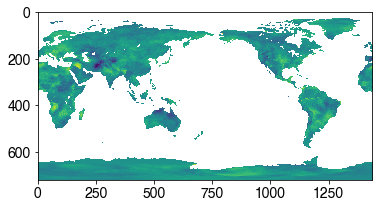

In [89]:
plt.imshow(trends_wave_days_tw_max_zonal_anom[:,:,5])

In [98]:
crop_ha_regrid_1d = np.reshape(crop_ha_regrid, [crop_ha_regrid.size, 1])
irrigation_regrid_1d = np.reshape(irrigation_data_regrid, [irrigation_data_regrid.size, 1])

kdd_trends_1d = np.reshape(kdd_trends, [kdd_trends.size, 1])
kdd_trends_zonal_anom_1d = np.reshape(kdd_trends_zonal_anom, [kdd_trends_zonal_anom.size, 1])

gdd_trends_1d = np.reshape(gdd_trends, [gdd_trends.size, 1])
gdd_trends_zonal_anom_1d = np.reshape(gdd_trends_zonal_anom, [gdd_trends_zonal_anom.size, 1])

trends_wave_days_t_max_1d = np.full([wave_days_t_max_trends[:,:,0,0].values.size, wave_days_t_max_trends.values.shape[2]], np.nan)
trends_wave_days_t_max_zonal_anom_1d = np.full([trends_wave_days_t_max_zonal_anom[:,:,0].size, trends_wave_days_t_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_max_1d = np.full([wave_days_tw_max_trends[:,:,0,0].values.size, wave_days_tw_max_trends.values.shape[2]], np.nan)
trends_wave_days_tw_max_zonal_anom_1d = np.full([trends_wave_days_tw_max_zonal_anom[:,:,0].size, trends_wave_days_tw_max_zonal_anom.shape[2]], np.nan)

trends_wave_days_t_min_1d = np.full([wave_days_t_min_trends[:,:,0,0].values.size, wave_days_t_min_trends.values.shape[2]], np.nan)
trends_wave_days_t_min_zonal_anom_1d = np.full([trends_wave_days_t_min_zonal_anom[:,:,0].size, trends_wave_days_t_min_zonal_anom.shape[2]], np.nan)

trends_wave_days_tw_min_1d = np.full([wave_days_tw_min_trends[:,:,0,0].values.size, wave_days_tw_min_trends.values.shape[2]], np.nan)
trends_wave_days_tw_min_zonal_anom_1d = np.full([trends_wave_days_tw_min_zonal_anom[:,:,0].size, trends_wave_days_tw_min_zonal_anom.shape[2]], np.nan)

for q in range(wave_days_t_max_trends.shape[2]):
    trends_wave_days_t_max_1d[:,q] = np.reshape(wave_days_t_max_trends[:,:,q,0].values, [wave_days_t_max_trends[:,:,q,0].values.size])
    trends_wave_days_t_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_max_zonal_anom[:,:,q], [trends_wave_days_t_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_max_1d[:,q] = np.reshape(wave_days_tw_max_trends[:,:,q,0].values, [wave_days_tw_max_trends[:,:,q,0].values.size])
    trends_wave_days_tw_max_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_max_zonal_anom[:,:,q], [trends_wave_days_tw_max_zonal_anom[:,:,q].size])
    
    trends_wave_days_t_min_1d[:,q] = np.reshape(wave_days_t_min_trends[:,:,q,0].values, [wave_days_t_min_trends[:,:,q,0].values.size])
    trends_wave_days_t_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_t_min_zonal_anom[:,:,q], [trends_wave_days_t_min_zonal_anom[:,:,q].size])
    
    trends_wave_days_tw_min_1d[:,q] = np.reshape(wave_days_tw_min_trends[:,:,q,0].values, [wave_days_tw_min_trends[:,:,q,0].values.size])
    trends_wave_days_tw_min_zonal_anom_1d[:,q] = np.reshape(trends_wave_days_tw_min_zonal_anom[:,:,q], [trends_wave_days_tw_min_zonal_anom[:,:,q].size])

In [99]:
q = 5

crop_ha_regrid_1d[crop_ha_regrid_1d==0] = np.nan
# crop_ha_regrid_1d[crop_ha_regrid_1d<1] = np.nan

# nn = np.where((~np.isnan(kdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_kdd = sm.OLS(kdd_trends_zonal_anom_1d[nn], X).fit()

# nn = np.where((~np.isnan(gdd_trends_zonal_anom_1d)) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_gdd = sm.OLS(gdd_trends_zonal_anom_1d[nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_t_max = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_min_zonal_anom_1d[:,q], [trends_wave_days_t_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_t_min = sm.OLS(trends_wave_days_t_min_zonal_anom_1d[:,q][nn], X).fit()

nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
X = sm.add_constant(crop_ha_regrid_1d[nn])
mdl_wave_days_tw_max = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_min_zonal_anom_1d[:,q], [trends_wave_days_tw_min_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(crop_ha_regrid_1d)))[0]
# X = sm.add_constant(crop_ha_regrid_1d[nn])
# mdl_wave_days_tw_min = sm.OLS(trends_wave_days_tw_min_zonal_anom_1d[:,q][nn], X).fit()

# IRRIGATION DATA
# nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[:,q], [trends_wave_days_t_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_t_max_irr = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][nn], X).fit()

# nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[:,q], [trends_wave_days_tw_max_zonal_anom_1d.shape[0], 1]))) & (~np.isnan(irrigation_regrid_1d)))[0]
# X = sm.add_constant(irrigation_regrid_1d[nn])
# mdl_wave_days_tw_max_irr = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][nn], X).fit()

In [201]:
# plt.scatter(irrigation_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:,q])
# plt.plot([x1, x2], [mdl_wave_days_t_max_irr.params[0], mdl_wave_days_t_max_irr.params[0]+x2*mdl_wave_days_t_max_irr.params[1]], '--k', lw=2)

In [73]:
slopes_t = []
slopes_tw = []
n = 10
for pct in range(0, 101, n):
    crop_ha_regrid_1d_sel = np.where((crop_ha_regrid_1d>pct) & (crop_ha_regrid_1d<pct+n))[0]
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_t_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_t_max_partial = sm.OLS(trends_wave_days_t_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_t.append(mdl_wave_days_t_max_partial.params[1])
    
    nn = np.where((~np.isnan(np.reshape(trends_wave_days_tw_max_zonal_anom_1d[crop_ha_regrid_1d_sel,q], [len(crop_ha_regrid_1d_sel), 1]))) & (~np.isnan(crop_ha_regrid_1d[crop_ha_regrid_1d_sel])))[0]
    if len(nn) > 50:
        X = sm.add_constant(crop_ha_regrid_1d[crop_ha_regrid_1d_sel[nn]])
        mdl_wave_days_tw_max_partial = sm.OLS(trends_wave_days_tw_max_zonal_anom_1d[:,q][crop_ha_regrid_1d_sel[nn]], X).fit()
        slopes_tw.append(mdl_wave_days_tw_max_partial.params[1])

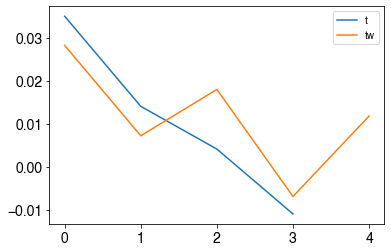

In [74]:
plt.plot(slopes_t, label='t')
plt.plot(slopes_tw, label='tw')
plt.legend()

In [168]:
mdl_wave_days_t_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     105.2
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           3.03e-24
Time:                        17:33:24   Log-Likelihood:                -2131.3
No. Observations:                2782   AIC:                             4267.
Df Residuals:                    2780   BIC:                             4278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9775      0.014     68.788      0.000       0.950       1.005
x1            -0.0151      0.001    -10.255      0.000      -0.018      -0.012
==============================================================================
Omnibus:                      125.622   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.468
Skew:                          -0.537   Prob(JB):                     5.19e-31
Kurtosis:                       2.778   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

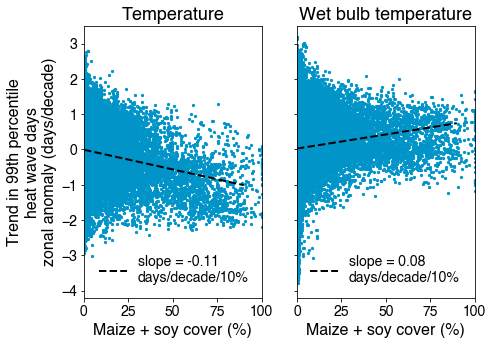

In [100]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,5))

x1 = 0
x2 = 90

ax1.scatter(crop_ha_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax1.plot([x1, x2], [mdl_wave_days_t_max.params[0], mdl_wave_days_t_max.params[0]+x2*mdl_wave_days_t_max.params[1]], '--k', lw=2, \
         label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_t_max.params[1]*10))
ax1.set_title('Temperature', fontsize=18)
ax1.set_xlabel('Maize + soy cover (%)')
ax1.set_ylabel('Trend in 99th percentile\nheat wave days\nzonal anomaly (days/decade)')
ax1.set_xlim([0, 100])
ax1.set_ylim([-4.2, 3.5])
ax1.legend(prop={'size': 14}, frameon=False)

ax2.scatter(crop_ha_regrid_1d, trends_wave_days_tw_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax2.plot([x1, x2], [mdl_wave_days_tw_max.params[0], mdl_wave_days_tw_max.params[0]+x2*mdl_wave_days_tw_max.params[1]], '--k', lw=2, \
        label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_tw_max.params[1]*10))
ax2.set_title('Wet bulb temperature', fontsize=18)
ax2.set_xlabel('Maize + soy cover (%)')
ax2.set_yticks(np.arange(-4, 3.1))
ax2.set_xlim([0, 100])
ax2.set_ylim([-4.2, 3.5])
ax2.legend(prop={'size': 14}, frameon=False)

# plt.savefig('figs/cropland-t-tw-zonal-mean-trends.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

# ax3.scatter(crop_ha_regrid_1d, trends_wave_days_t_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax3.plot([x1, x2], [mdl_wave_days_t_min.params[0], mdl_wave_days_t_min.params[0]+x2*mdl_wave_days_t_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_t_min.params[1]*10))
# ax3.set_title('T_min, q = %d'%q)
# ax3.set_xlabel('Crop cover (%)')
# ax3.set_ylabel('Cold wave days trend\nzonal anomaly\n(days/decade)')
# ax3.set_xlim([0, 100])
# # ax3.set_ylim([-4, 4])
# ax3.legend()

# ax4.scatter(crop_ha_regrid_1d, trends_wave_days_tw_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax4.plot([x1, x2], [mdl_wave_days_tw_min.params[0], mdl_wave_days_tw_min.params[0]+x2*mdl_wave_days_tw_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_tw_min.params[1]*10))
# ax4.set_title('TW_min, q = %d'%q)
# ax4.set_xlabel('Crop cover (%)')
# ax4.set_xlim([0, 100])
# # ax4.set_ylim([-4, 4])
# ax4.legend()


In [72]:
ind_no_crop = np.where((crop_ha_regrid_1d<=1))[0]
ind_low_crop = np.where((crop_ha_regrid_1d>1) & (crop_ha_regrid_1d<=25))[0]
ind_high_crop = np.where((crop_ha_regrid_1d>25))[0]

t_max_trend_no_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_no_crop, q])
t_max_trend_low_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_low_crop, q])
t_max_trend_high_crop = np.nanmedian(trends_wave_days_t_max_zonal_anom_1d[ind_high_crop, q])

tw_max_trend_no_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_no_crop, q])
tw_max_trend_low_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_low_crop, q])
tw_max_trend_high_crop = np.nanmedian(trends_wave_days_tw_max_zonal_anom_1d[ind_high_crop, q])


print(t_max_trend_no_crop, t_max_trend_low_crop, t_max_trend_high_crop)
print(tw_max_trend_no_crop, tw_max_trend_low_crop, tw_max_trend_high_crop)

0.8347558764880052 0.9666224785926698 0.7906920555326428
0.7798830927907219 0.9551428739071759 1.1489443741759706
